In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import ticker

sns.set(style='white',  font='sans-serif', font_scale=2)


In [2]:
dataset_name = 'braf'

In [3]:
dfo = pd.read_pickle('../results/braf/braf.pkl')

In [7]:
df1s = []
df2s  = []
for i in [1,2,3]:
    df = dfo[dfo.repeat == 'repeat_%s' % i]
    
    df1 = df.groupby(['cliff', 'fold']).train_n_triplets.max().reset_index()
    df1 = df1.groupby('cliff').train_n_triplets.mean().to_frame().reset_index() 
    df1[['cliff_lower', 'cliff_upper']] = df1.cliff.apply(pd.Series)
    
    dfx = df.groupby(['cliff', 'fold']).val_rmse.rolling(1).mean().reset_index()
    
    df2 = dfx.groupby(['cliff', 'fold']).val_rmse.min().reset_index()
    df2 = df2.groupby('cliff').val_rmse.mean().to_frame().reset_index() 
    df2[['cliff_lower', 'cliff_upper']] = df2.cliff.apply(pd.Series)

    
    df1s.append(df1)
    df2s.append(df2)

In [8]:
df1 = pd.concat(df1s).groupby('cliff').mean()
df2 = pd.concat(df2s).groupby('cliff').mean()

0 17


/tmp/ipykernel_236105/1073061318.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels)


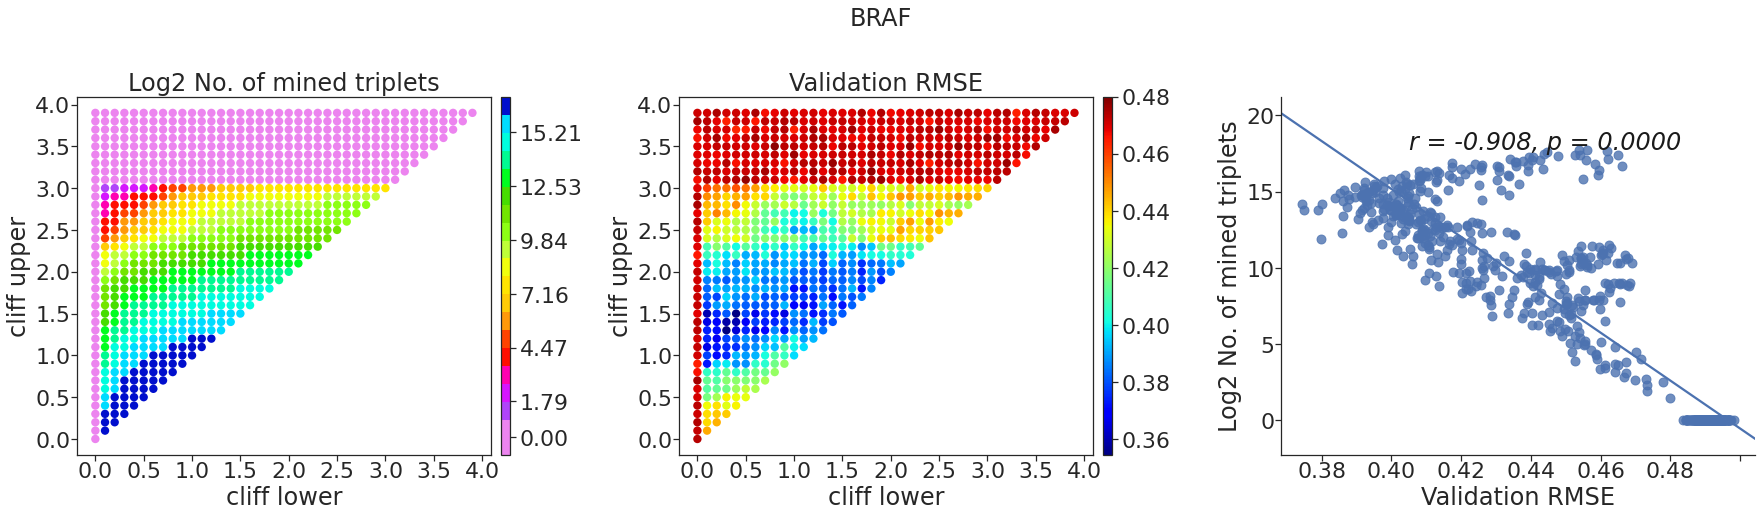

In [14]:
ticks =  [0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3., 3.5, 4]

dfp1 = df1
dfp1['trps'] = dfp1.train_n_triplets.astype(int)

dfp1['trps2'] = dfp1.trps.replace(0, np.nan)

dfp1['trps2'] = np.log2(dfp1['trps2'])

v = dfp1.trps2.dropna().sort_values().astype(int)
bds = [0]
bds1 = np.linspace(v.min(), v.max(), 20)
print(v.min(), v.max())

#bds1 = np.logspace(np.log2(v.min()),  np.log2(v.max()), num = 100, base = 2)

bds.extend(bds1)

bds = pd.Series(bds).astype(float).to_list()

base_cmaps = ['Greys', 'gist_ncar_r'] #gist_ncar_r 

n_base = len(base_cmaps)
N=[1, len(bds1)]# number of colors  to extract from each cmap, sum(N)=len(classes)
colors = np.concatenate([plt.get_cmap(name)(np.linspace(0.1, 0.9, N[i])) for i,name in zip(range(n_base),base_cmaps)])
cmap = ListedColormap(colors)

boundary_norm = BoundaryNorm(bds, cmap.N)


fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(25, 7.5), gridspec_kw = {'width_ratios':[1,1,0.95]})

s = 70
marker = 'o'
lw = 0

im = ax1.scatter(x = dfp1.cliff_lower, 
                 y = dfp1.cliff_upper, #vmax = dfp1.trps.max(), 
                 c = np.log2(dfp1.trps+1), 
                 norm = boundary_norm, #marker = ',',
                 marker = marker,
                 edgecolors='k', 
                 lw=lw, 
                 s = s, cmap= cmap, label = 'trps2')

# fmt = ticker.ScalarFormatter(useMathText=True)
# fmt.set_powerlimits((0,0))

cbar1 = fig.colorbar(im, ax=ax1, aspect=40, pad = 0.02,)

ax1.tick_params(left='off',  bottom='off', pad=.3,)

im = ax2.scatter(x = df2.cliff_lower, 
                 y = df2.cliff_upper, 
                 marker = marker,
                 c = df2.val_rmse, 
                 s = s, cmap= 'jet', 
                 edgecolors='k', lw=lw,  
                 vmax = 0.48,
                 label = 'val_rmse')

cbar2 = fig.colorbar(im, ax=ax2, aspect=40, pad = 0.02)
fig.tight_layout()


for ax, title in zip([ax1, ax2], ['Log2 No. of mined triplets', 'Validation RMSE']): 
    ax.set_ylabel('cliff upper')
    ax.set_xlabel('cliff lower')
    ax.tick_params(left='off',  bottom='off', pad=.3,)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(title)

x = df2.val_rmse
y = np.log2(df1.train_n_triplets + 1)

sns.regplot(x, y, ax = ax3, ci=0, truncate= False, color = 'b', 
            scatter_kws={'s':80, 'color':'b'})

r, p = stats.pearsonr(x, y)


ax3.text(x.mean()-0.05, y.max(), 
         'r = %.3f, p = %.4f' % (r, p), 
         fontstyle='italic', color = 'k')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.tick_params(left='off',  bottom='off', pad=.5,)
ax3.set_ylabel('Log2 No. of mined triplets')
ax3.set_xlabel('Validation RMSE')

labels = [item.get_text() for item in cbar2.ax.yaxis.get_ticklabels()]
ax3.set_xticklabels(labels)

st = fig.suptitle(dataset_name.upper(), fontsize="medium")

fig.tight_layout()

fig.savefig('../results/cliff_performance_%s.png' % dataset_name, dpi = 300, bbox_inches='tight')
fig.savefig('../results/cliff_performance_%s.pdf' % dataset_name, dpi = 300, bbox_inches='tight')

In [10]:
df2.loc[[df2.val_rmse.idxmin()]]

,val_rmse,cliff_lower,cliff_upper
cliff,,,
"(0.3, 1.3)",0.35444,0.3,1.3


In [11]:
df1.loc[[df1.train_n_triplets.idxmax()]]

,train_n_triplets,cliff_lower,cliff_upper,trps,trps2
cliff,,,,,
"(0.4, 0.4)",219963.2,0.4,0.4,219963,17.746901


In [12]:
dfa = x.to_frame().join(y)
dfa['cl'] = dfa.index.map(lambda x:x[0])
dfa['cu'] = dfa.index.map(lambda x:x[1])
dfa = dfa[dfa.cl == dfa.cu]

x = dfa.val_rmse
y = dfa.train_n_triplets

Text(0.3784758427739145, 17.746909213253893, 'r = -0.761, p = 0.0000')

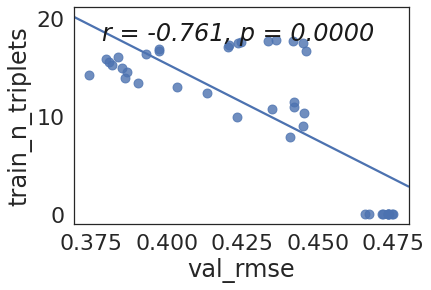

In [13]:
fig, ax3 = plt.subplots()
sns.regplot(x, y, ci=0, ax = ax3, truncate= False, color = 'b', 
            scatter_kws={'s':80, 'color':'b'})


r, p = stats.pearsonr(x, y)


ax3.text(x.mean()-0.05, y.max(), 
         'r = %.3f, p = %.4f' % (r, p), 
         fontstyle='italic', color = 'k')


In [1]:
df2

NameError: name 'df2' is not defined